In [78]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pickle
import os

In [127]:
base_dir = "../results"
# TODO: store meta info alongside results
dataset = "IMDB"
model = "JWA"
al_sampler = "random"
exp_id = f"{dataset}-{al_sampler}"
experiments = []


for filename in os.listdir(base_dir):
    if filename.startswith(exp_id) and filename.endswith(".pkl"): 
        with open(os.path.join(base_dir, filename), "rb") as f:
            results = pickle.load(f)
            experiments.append(results)

In [122]:
interpreters = ["deeplift", "grad-shap", "int-grad"]
interpret_pairs = list(itertools.combinations(interpreters, 2))

In [123]:
def plot_last_epoch(experiments, interpret_pairs):
    agreement_dict = defaultdict(list)
    train_scores = []
    eval_scores = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            results["labeled"], results["agreement"], results["train"], results["eval"]
        ),
        1,
    ):
        for ip in interpret_pairs:
            agreement_dict[ip].append(list(A)[-1][ip])
        train_scores.append(list(T)[-1]["loss"])
        eval_scores.append(list(E)[-1]["accuracy"]/100)

    fig, axs = plt.subplots(3, figsize=(12, 20), sharex=True)
    axs[0].scatter(results["labeled"], train_scores, color="r")
    axs[0].plot(results["labeled"], train_scores, color="r")
    axs[0].set_ylabel("Loss")
    axs[1].scatter(results["labeled"], eval_scores, color="g")
    axs[1].plot(results["labeled"], eval_scores, color="g")
    axs[1].set_ylabel("Accuracy")
    for ip, agrs in agreement_dict.items():
        axs[2].scatter(results["labeled"], agrs)
        axs[2].plot(results["labeled"], agrs)
        
    axs[2].set_ylabel("Agreement")
    axs[2].set_xlabel("# labeled")
    axs[2].legend(interpret_pairs)

In [133]:
def extract_last_epoch(experiments, interpret_pairs):
    dfs_tr = []
    dfs_agr = []
    for exp_index, experiment in enumerate(experiments):

        train = experiment["train"]
        train_vals = [tr[-1]["loss"] for tr in train]
        test = experiment["eval"]
        test_vals = [te[-1]["accuracy"] for te in test]
        labeled_vals = experiment["labeled"]
        iter_vals = list(range(len(labeled_vals)))
        df_tr = pd.DataFrame(
            {
                "al_iter": iter_vals,
                "labeled": labeled_vals,
                "train_loss": train_vals,
                "test_accuracy": test_vals,
            }
        )
        df_tr["experiment"] = exp_index
        df_tr.set_index(["experiment", "al_iter"], inplace=True)

        agreement_vals = []
        interpret_vals = []
        agreement = experiment["agreement"]
        for ip in interpret_pairs:
            for a in agreement:
                interpret_vals.append(ip)
                agreement_vals.append(a[-1][ip])

        df_agr = pd.DataFrame(
            {
                "al_iter": iter_vals * len(interpret_pairs),
                "labeled": labeled_vals * len(interpret_pairs),
                "agreement": agreement_vals,
                "interpreter": interpret_vals,
            }
        )
        df_agr["experiment"] = exp_index
        df_agr.set_index(["experiment", "al_iter", "interpreter"], inplace=True)

        dfs_tr.append(df_tr)
        dfs_agr.append(df_agr)
    new_df_tr = pd.concat(dfs_tr)
    new_df_agr = pd.concat(dfs_agr)
    return new_df_tr, new_df_agr


def plot_last_epoch_ci(experiments, intepret_pairs, dataset, model, al_sampler):
    df_tr, df_agr = extract_last_epoch(experiments, intepret_pairs)
    fig, axs = plt.subplots(3, figsize=(12, 20), sharex=True)
    axs[0].set_title(f"{dataset} - {model} - {al_sampler}")
    sns.lineplot(ax=axs[0], data=df_tr, x="labeled", y="train_loss", color="r")
    sns.lineplot(ax=axs[1], data=df_tr, x="labeled", y="test_accuracy", color="g")
    sns.lineplot(
        ax=axs[2],
        data=df_agr,
        x="labeled",
        y="agreement",
        hue="interpreter",
        style="interpreter",
        markers=True,
        dashes=True,
    )
    plt.show()

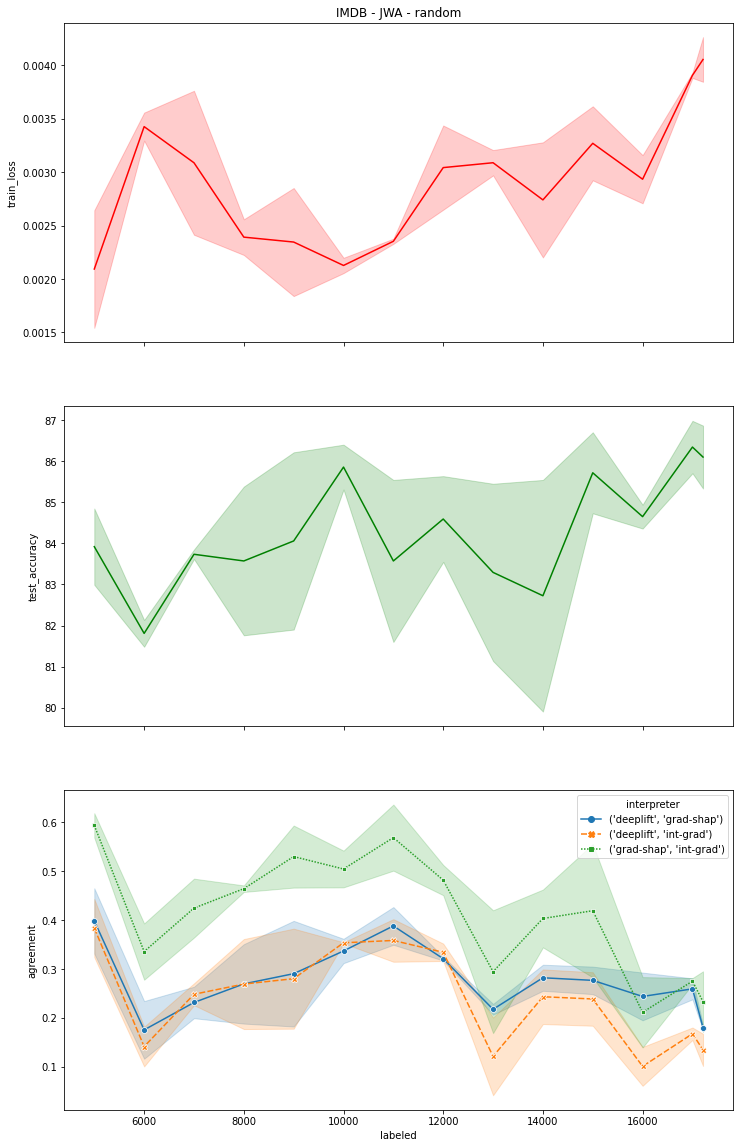

In [134]:
plot_last_epoch_ci(experiments, interpret_pairs, dataset, model, al_sampler)

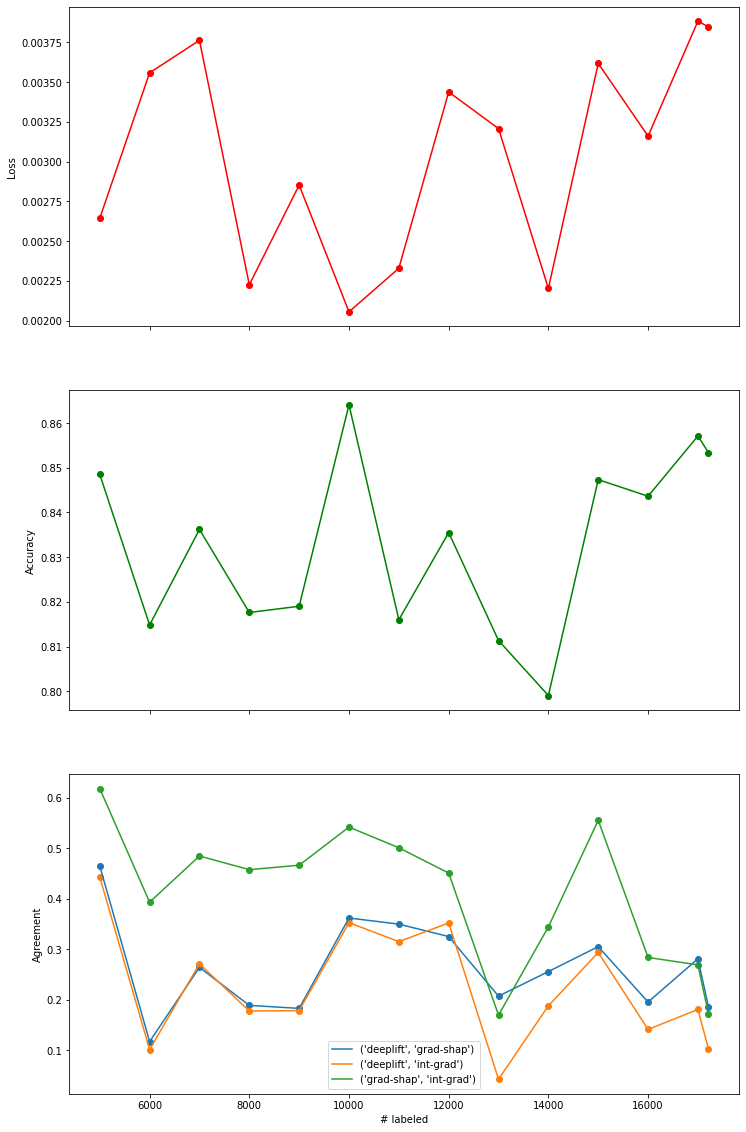

In [109]:
experiment_idx = 0
plot_last_epoch(experiments[experiment_idx], interpret_pairs)
plt.show()

In [116]:
def plot_epochwise_trend(results, interpreter):
    agreements = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            results["labeled"], results["agreement"], results["train"], results["eval"]
        ),
        1,
    ):

        for a in A:
            agreement = a[interpreter]
            if np.isnan(agreement):
                agreement = 0
            agreements.append(agreement)

    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(agreements)), agreements)
    plt.plot(range(len(agreements)), agreements)
    plt.vlines(
        range(len(A), len(results["labeled"]) * len(A), len(A)),
        ymin=-0.2,
        ymax=1,
        color="r",
    )
    plt.ylabel("Agreeement")
    plt.title(interpreter)

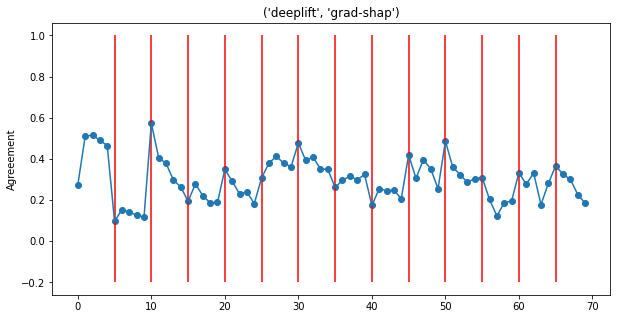

In [117]:
experiment_idx = 0
interpret_idx = 0
plot_epochwise_trend(experiments[experiment_idx], interpret_pairs[0])
plt.show()